In [1]:
# Imports
import numpy as np

import cv2
from PIL import Image

import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

In [2]:
# The caffe module needs to be on the Python path
import sys
caffe_root = '../' # Run from {caffe_root}/examples (else change)
sys.path.insert(0, caffe_root + 'python')
import caffe

**Creating LMDB Database**
- HDF5: Simple format to read/write. HDF5 files are always read into memory and this can cause memory capacity issues.
- LMDB: Uses memory-mapped files (better I/O performance) and works well with large datasets. LMDB provides key-value storage. Key will simply be a string version of an ID value and the value will be a serialized version of the `Datum` class in Caffe
---

**Data Preparation**
- Adjust the contrast of images using `Histogram Equalization` technique
- Resize images to a standard size
- Split training data into 2 sets: Training and Validation
- Store training andvalidation in 2 LMDB databases
---

- [Create LMDB reference](https://github.com/adilmoujahid/deeplearning-cats-dogs-tutorial/blob/master/code/create_lmdb.py)
- [Creating an LMDB database in Python](http://deepdish.io/2015/04/28/creating-lmdb-in-python/)
- [Training and deploying deep learning networks with Caffe](http://rodriguezandres.github.io/2016/04/28/caffe/)
- [python-lmdb-mnist](https://github.com/DeeperCS/python-lmdb-mnist)
- [cats-and-dogs-kaggle](https://github.com/karandesai-96/cats-and-dogs-kaggle/blob/master/preprocess.py)
- [Training Multi-Layer Neural Network with Caffe](http://nbviewer.jupyter.org/github/joyofdata/joyofdata-articles/blob/master/deeplearning-with-caffe/Neural-Networks-with-Caffe-on-the-GPU.ipynb)

In [3]:
from caffe.proto import caffe_pb2
import glob
import random
import lmdb

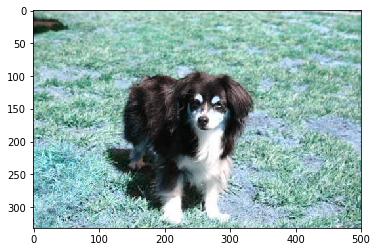

In [4]:
# OpenCV: BGR format
temp = cv2.imread('./dogVcat/train/dog.20.jpg')
plt.imshow(temp)

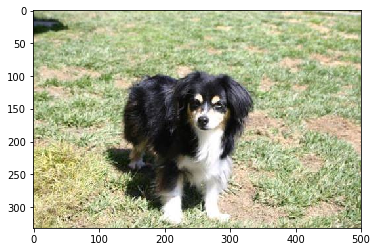

In [5]:
# OpenCV: RGB
temp_rgb = cv2.imread('./dogVcat/train/dog.20.jpg')
temp_rgb = cv2.cvtColor(temp_rgb, cv2.COLOR_BGR2RGB)
plt.imshow(temp_rgb)

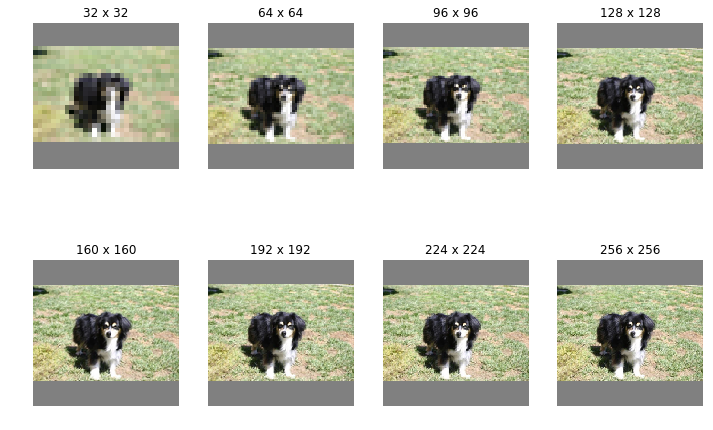

In [6]:
# Resize image
def resize_image(img, size):
    """
    input: 
        img = PIL image
        size = side length of square image (output)
    """
    # Resizing image
    x, y = img.size
    if x > y:
        nx = size
        ny = int(size * y/x + 0.5)
    else:
        nx = int(size * x/y + 0.5)
        ny = size
    temp_res = img.resize((nx, ny), resample=Image.ANTIALIAS)
    
    # Padding borders to create a square image
    temp_pad = Image.new('RGB', (size, size), (128, 128, 128))
    temp = ((size - nx)//2, (size - ny)//2)
    temp_pad.paste(temp_res, temp)
    return temp_pad

# Test image resize
dog = Image.open('./dogVcat/train/dog.20.jpg')

sizes = [32, 64, 96, 128, 160, 192, 224, 256]

plt.figure(figsize=(12, 8))

for i, size in enumerate(sizes):
    temp = resize_image(dog, size)
    plt.subplot(2, 4, i+1)
    plt.imshow(temp)
    plt.axis('off')
    plt.title('{} x {}'.format(size, size))
    
plt.show()

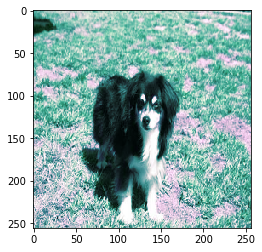

In [7]:
# Histogram Equalization, resize and pad image
def transform_image(img, img_width, img_height):
    # Histogram Equalization for 3 channels (R, G, B)
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 2])

    # Resizing image
    img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)
    return img

# Select image width and height to be 256 pixels
temp = cv2.imread('./dogVcat/train/dog.20.jpg')
temp = transform_image(temp, 256, 256)
plt.imshow(temp)

In [8]:
# Datum is a Google Protobuf Message class used to store data and a label.
def create_datum(img, label):
    """
    3 channels for R, G, B
    img: numpy.ndarray of shape (256, 256, 3) in GBR format
    `np.rollaxis` -> converts GBR to RGB by reordering axis.
    """
    return caffe_pb2.Datum(channels=3,
                          width=256,
                          height=256,
                          label=label,
                          data=np.rollaxis(img, 2).tostring())

In [9]:
!pwd

/home/ankoor/caffe/examples


In [10]:
# LMDB
train_lmdb = '/home/ankoor/caffe/examples/dogVcat/train_lmdb'
val_lmdb = '/home/ankoor/caffe/examples/dogVcat/val_lmdb'

train_data = [img for img in glob.glob('./dogVcat/train/*jpg')]
test_data = [img for img in glob.glob('./dogVcat/test/*jpg')]

# Shuffle training data
random.shuffle(train_data)

In [11]:
# Create train lmdb
train_labels = []
map_size = 1e12 # X.nbytes * 10
in_db = lmdb.open(train_lmdb, map_size=map_size)
with in_db.begin(write=True) as txn:
    # txn is a Transaction object
    for idx, img_path in enumerate(train_data):
        if idx % 8 == 0:
            continue
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = transform_image(img, 256, 256)
        if 'train/dog' in img_path:
            label = 1
        else:
            label = 0
        train_labels.append(label)
        datum = create_datum(img, label)
        txn.put('{:0>5d}'.format(idx), datum.SerializeToString()) # {:0>5d} -> pad and right align string
        if idx % 2500 == 0:
            print '{:0>5d}'.format(idx) + ':' + img_path
in_db.close()
print '# of Dog images in train set: ', sum(train_labels)

02500:./dogVcat/train/dog.11071.jpg
07500:./dogVcat/train/dog.9160.jpg
12500:./dogVcat/train/dog.4905.jpg
17500:./dogVcat/train/cat.1693.jpg
22500:./dogVcat/train/dog.7563.jpg
# of Dog images in train set:  10948


In [12]:
# Create validation lmdb
val_labels = []
map_size = 1e12 # X.nbytes * 10
in_db = lmdb.open(val_lmdb, map_size=map_size)
with in_db.begin(write=True) as txn:
    # txn is a Transaction object
    for idx, img_path in enumerate(train_data):
        if idx % 8 != 0:
            continue
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = transform_image(img, 256, 256)
        if 'train/dog' in img_path:
            label = 1
        else:
            label = 0
        val_labels.append(label)
        datum = create_datum(img, label)
        txn.put('{:0>5d}'.format(idx), datum.SerializeToString()) # {:0>5d} -> pad and right align string
        if idx % 2500 == 0:
            print '{:0>5d}'.format(idx) + ':' + img_path
in_db.close()
print '# of Dog images in val set: ', sum(val_labels)

00000:./dogVcat/train/cat.10090.jpg
05000:./dogVcat/train/cat.11595.jpg
10000:./dogVcat/train/cat.2822.jpg
15000:./dogVcat/train/dog.892.jpg
20000:./dogVcat/train/dog.9877.jpg
# of Dog images in val set:  1552


**Check Content of LMDB**

```python
def get_lmdb_content(lmdb_path, id):
    """
    Args:
        lmdb_path (str): LMDB database path
        id (str): id
    Returns:
        lmdb content (label, feature) for id
    """
    db = lmdb.open(lmdb_path, readonly=True)
    txn = db.begin()
    
    raw_datum = txn.get(id)
    datum = caffe_pb2.Datum()
    datum.ParseFromString(raw_datum)
    
    feature = caffe.io.datum_to_array(datum)
    label = datum.label
    
    return (label, feature)

get_lmdb_content('/home/ankoor/caffe/examples/dogVcat/val_lmdb', '00123')
```

**Generating the mean image of training data**

In [13]:
! /home/ankoor/caffe/build/tools/compute_image_mean -backend=lmdb /home/ankoor/caffe/examples/dogVcat/train_lmdb /home/ankoor/caffe/examples/dogVcat/mean.binaryproto

**Create Network**

In [14]:
from caffe import layers as L
from caffe import params as P

In [15]:
# Create a simple CNN: [conv - relu - pool] - [fc - relu] - [fc - softmax]
def SimpleNet(lmdb_path, batch_size):
    n = caffe.NetSpec()
    # Data layer
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB,
                             source=lmdb_path, transform_param=dict(scale=1./255),
                             ntop=2)
    # Convolution layer 1
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=16, weight_filler=dict(type='xavier'))
    #  ReLU 1
    n.relu1 = L.ReLU(n.conv1, in_place=True)
    # Pooling
    n.pool1 = L.Pooling(n.relu1, kernel_size=2, stride=1, pool=P.Pooling.MAX)
    # Fully connected layer 1
    n.fc1 = L.InnerProduct(n.pool1, num_output=250, weight_filler=dict(type='xavier'))
    # ReLU 2
    n.relu2 = L.ReLU(n.fc1, in_place=True)
    # Fully connected layer 2
    n.fc2 = L.InnerProduct(n.relu2, num_output=2, weight_filler=dict(type='xavier'))
    # Softmax loss
    n.loss = L.SoftmaxWithLoss(n.fc2, n.label)
    return n.to_proto()

In [16]:
# Training: /home/ankoor/caffe/examples
with open('/home/ankoor/caffe/examples/dogVcat/simple_net_train.prototxt', 'w') as f:
    f.write(str(SimpleNet('/home/ankoor/caffe/examples/dogVcat/train_lmdb', 100)))
    
# Validation
with open('/home/ankoor/caffe/examples/dogVcat/simple_net_val.prototxt', 'w') as f:
    f.write(str(SimpleNet('/home/ankoor/caffe/examples/dogVcat/val_lmdb', 100)))

In [18]:
# Training prototxt
!cat ./dogVcat/simple_net_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156885937
  }
  data_param {
    source: "/home/ankoor/caffe/examples/dogVcat/train_lmdb"
    batch_size: 100
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 16
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 1
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "pool1"
  top: "fc1"
  inner_product_param {
    num_output: 250
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "relu2"
  type: "ReLU"
  bottom: "fc1"
  top: "fc1"
}
layer {
  name: "fc2"
  type: "InnerProduct"
  bottom: "fc1"
  top: "fc2"
  inner_product_param {
    num_o

In [19]:
# Validation prototxt
!cat ./dogVcat/simple_net_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156885937
  }
  data_param {
    source: "/home/ankoor/caffe/examples/dogVcat/train_lmdb"
    batch_size: 100
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 16
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 1
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "pool1"
  top: "fc1"
  inner_product_param {
    num_output: 250
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "relu2"
  type: "ReLU"
  bottom: "fc1"
  top: "fc1"
}
layer {
  name: "fc2"
  type: "InnerProduct"
  bottom: "fc1"
  top: "fc2"
  inner_product_param {
    num_o

**Define Solver**

In [20]:
!pwd

/home/ankoor/caffe/examples


In [21]:
#!python /home/ankoor/caffe/python/draw_net.py /home/ankoor/caffe/examples/dogVcat/simple_net_train.prototxt /home/ankoor/caffe/examples/dogVcat/simple_net.png

In [22]:
solver_text = """train_net: "/home/ankoor/caffe/examples/dogVcat/simple_net_train.prototxt"
test_net: "/home/ankoor/caffe/examples/dogVcat/simple_net_val.prototxt"
test_iter: 1000
test_interval: 1000
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
lr_policy: "inv"
gamma: 0.0001
power: 0.75
display: 1000
max_iter: 10000
snapshot: 5000
snapshot_prefix: "/home/ankoor/caffe/examples/dogVcat/simple_net_snapshot"
solver_mode: GPU
"""

# Write solver prototext
with open('/home/ankoor/caffe/examples/dogVcat/simple_net_solver.prototxt', 'w') as f:
    f.write(solver_text)

In [23]:
# Validation prototxt
!cat ./dogVcat/simple_net_solver.prototxt

train_net: "/home/ankoor/caffe/examples/dogVcat/simple_net_train.prototxt"
test_net: "/home/ankoor/caffe/examples/dogVcat/simple_net_val.prototxt"
test_iter: 1000
test_interval: 1000
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
lr_policy: "inv"
gamma: 0.0001
power: 0.75
display: 1000
max_iter: 10000
snapshot: 5000
snapshot_prefix: "/home/ankoor/caffe/examples/dogVcat/simple_net_snapshot"
solver_mode: GPU


**Loading Solver**

In [24]:
# Set Caffe to GPU mode and load the net from disk
caffe.set_device(0)
caffe.set_mode_gpu()

In [25]:
# load the solver and create train and val nets
solver = caffe.SGDSolver('/home/ankoor/caffe/examples/dogVcat/simple_net_solver.prototxt')

**Architecture of `Simple Network`**
- Check dimensions of features (`blobs`) and `parameters`

In [26]:
# Blob: Each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (100, 3, 256, 256)),
 ('label', (100,)),
 ('conv1', (100, 16, 252, 252)),
 ('pool1', (100, 16, 251, 251)),
 ('fc1', (100, 250)),
 ('fc2', (100, 2)),
 ('loss', ())]

In [27]:
# Parameters
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (16, 3, 5, 5)), ('fc1', (250, 1008016)), ('fc2', (2, 250))]

**Run Forward Pass**
- Checking that everything is loaded

In [28]:
# Train net
print solver.net.forward()

# Test net
print solver.test_nets[0].forward()

{'loss': array(0.7042746543884277, dtype=float32)}
{'loss': array(0.6749691963195801, dtype=float32)}


Train labels:  [ 1.  0.  1.  0.  1.  0.  0.  1.  0.  1.]


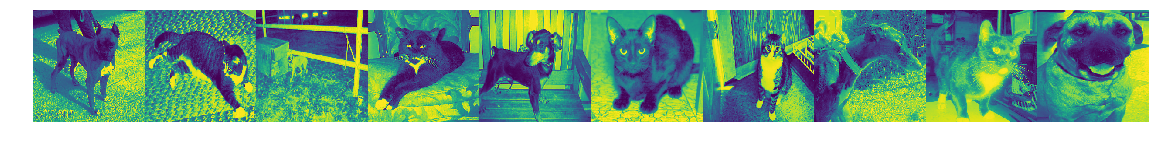

In [29]:
# Tile first 10 train images
img_arr = solver.net.blobs['data'].data[:10, 0].transpose(1, 0, 2).reshape(256, 10*256)
plt.figure(figsize=(20,10))
plt.imshow(img_arr)
plt.axis('off')
print 'Train labels: ', solver.net.blobs['label'].data[:10]

Test labels:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  1.]


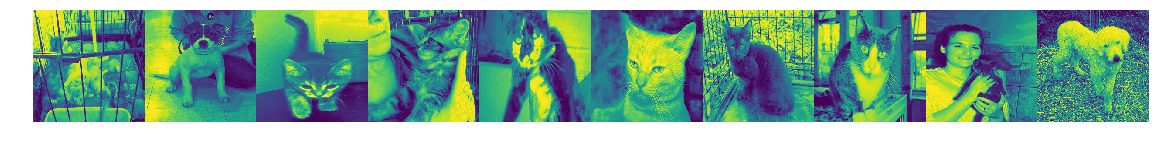

In [30]:
# Tile first 10 test images
img_arr = solver.test_nets[0].blobs['data'].data[:10, 0].transpose(1, 0, 2).reshape(256, 10*256)
plt.figure(figsize=(20,10))
plt.imshow(img_arr)
plt.axis('off')
print 'Test labels: ', solver.test_nets[0].blobs['label'].data[:10]

**One SGD Step**

In [31]:
# 1 SGD step
solver.step(1)

(-0.5, 24.5, 15.5, -0.5)

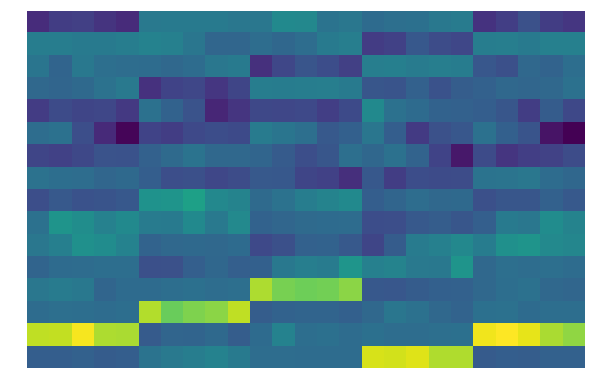

In [38]:
# Visualize updates to first layer: 16 (4 x 4) filters of size 5 x 5
filter_arr = solver.net.params['conv1'][0].diff[:, 0].reshape(4, 4, 5, 5).transpose(0, 2, 1, 3).reshape(4*4, 5*5)
plt.figure(figsize=(10,10))
plt.imshow(filter_arr)
plt.axis('off')

**Training** (Using Python)

In [44]:
%%time
n_iter = 1000
test_interval = 50
train_loss = np.zeros(n_iter)
test_acc = np.zeros(int(np.ceil(n_iter / test_interval)))
output = np.zeros((n_iter, 10, 2))

# Main `solver` loop
for i in range(n_iter):
    # Caffe SGD step
    solver.step(1)
    
    # Store train loss
    train_loss[i] = solver.net.blobs['loss'].data
    
    # Store the output on the first test batch
    solver.test_nets[0].forward(start='conv1') # start the forward pass at conv1 to avoid loading new data
    output[i] = solver.test_nets[0].blobs['fc2'].data[:10] # 'fc2' defines score in train.prototxt
    
    # Run full test
    if i % test_interval == 0:
        print 'Iteration', i, 'testing...'
        correct = 0
        for j in range(100):
            solver.test_nets[0].forward()
            test_score = solver.test_nets[0].blobs['fc2'].data.argmax(1)
            test_labels = solver.test_nets[0].blobs['label'].data
            correct += sum(test_score == test_labels)
        test_acc[i // test_interval] = correct/1e4

Iteration 0 testing...
Iteration 50 testing...
Iteration 100 testing...
Iteration 150 testing...
Iteration 200 testing...
Iteration 250 testing...
Iteration 300 testing...
Iteration 350 testing...
Iteration 400 testing...
Iteration 450 testing...
Iteration 500 testing...
Iteration 550 testing...
Iteration 600 testing...
Iteration 650 testing...
Iteration 700 testing...
Iteration 750 testing...
Iteration 800 testing...
Iteration 850 testing...
Iteration 900 testing...
Iteration 950 testing...
CPU times: user 15min 26s, sys: 2min 46s, total: 18min 12s
Wall time: 14min 53s


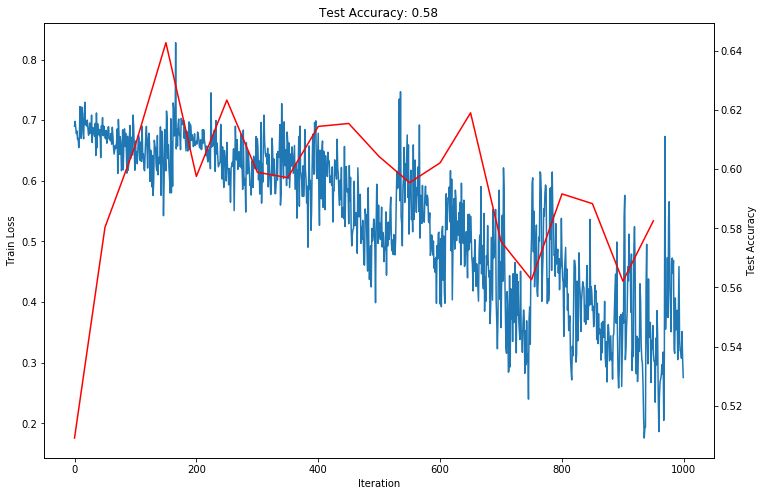

In [62]:
# Plot training loss and test accuracy
# https://python4astronomers.github.io/plotting/advanced.html
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(np.arange(n_iter), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Train Loss')
ax2.set_ylabel('Test Accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

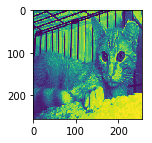

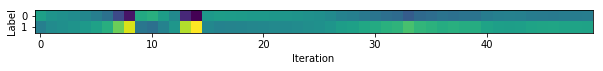

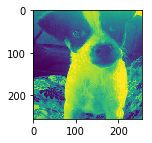

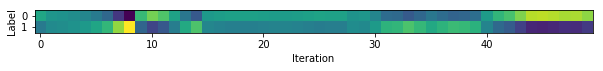

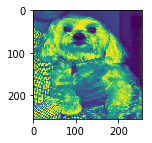

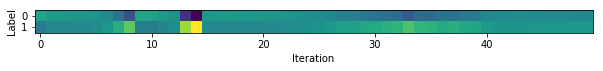

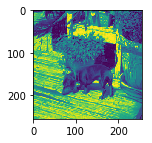

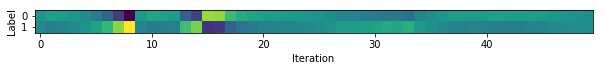

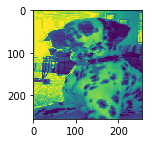

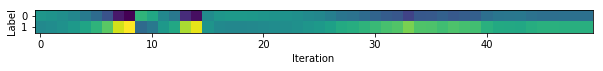

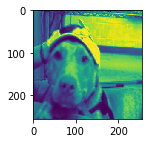

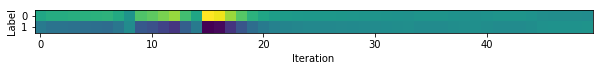

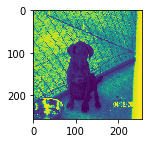

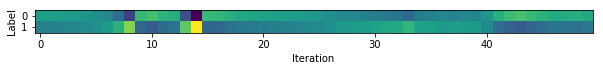

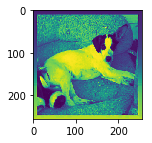

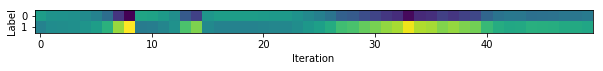

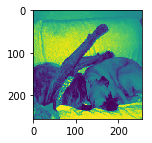

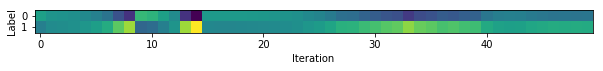

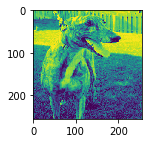

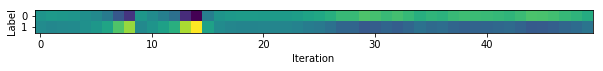

In [66]:
# Visualize training scores progression
for i in range(10):
    plt.figure(figsize=(2, 2))
    plt.imshow(solver.test_nets[0].blobs['data'].data[i, 0])
    plt.figure(figsize=(10, 4))
    plt.imshow(np.exp(output[:50, i].T)/np.exp(output[:50, i].T).sum(0), interpolation='nearest')
    plt.xlabel('Iteration')
    plt.ylabel('Label')

### Experiment: Architecture and Optimization

**Define Solver**

In [72]:
# Solver parameter
s = caffe_pb2.SolverParameter()

# Set a random seed for reproducable experiments
s.random_seed = 0xCAFFE

# Specify locations of the train and test networks
s.train_net = "/home/ankoor/caffe/examples/dogVcat/custom_net_train.prototxt"
s.test_net.append("/home/ankoor/caffe/examples/dogVcat/custom_net_test.prototxt")

# Test after every `n` training iterations
s.test_interval = 50

# Test on `batch size` batches each time
s.test_iter.append(100)

# Training iterations: # of times to update the net
s.max_iter = 1000

# Solver types: `SGD`, `Adam`, `Nestrov`, etc.
s.type = "SGD"

# Set the initial learning rate for SGD
s.base_lr = 0.01

# Set momentum to accelerate learning by taking weighted average of current and previous updates
s.momentum = 0.9

# Set weight decay to regularize and prevent overfitting
s.weight_decay = 1e-4

# Set `learning policy` to define how the learning rate changes during training
s.lr_policy = 'inv'
s.gamma = 0.0001
s.power = 0.75

# Display the current training loss and accuracy every `m` iterations
s.display = 100

# Snapshot are files used to store networks that have been trained
s.snapshot = 250 # Snapshot every 250 iterations -> 4 times in 1000 training iterations
s.snapshot_prefix = "/home/ankoor/caffe/examples/dogVcat/custom_net_snapshot"

# Train on GPU
s.solver_mode = caffe_pb2.SolverParameter.GPU

# Write the solver to a file
solver_config_path = "/home/ankoor/caffe/examples/dogVcat/custom_net_solver.prototxt"
with open(solver_config_path, 'w') as f:
    f.write(str(s))
    
!cat /home/ankoor/caffe/examples/dogVcat/custom_net_solver.prototxt

train_net: "/home/ankoor/caffe/examples/dogVcat/custom_net_train.prototxt"
test_net: "/home/ankoor/caffe/examples/dogVcat/custom_net_test.prototxt"
test_iter: 100
test_interval: 50
base_lr: 0.00999999977648
display: 100
max_iter: 1000
lr_policy: "inv"
gamma: 9.99999974738e-05
power: 0.75
momentum: 0.899999976158
weight_decay: 9.99999974738e-05
snapshot: 250
snapshot_prefix: "/home/ankoor/caffe/examples/dogVcat/custom_net_snapshot"
solver_mode: GPU
random_seed: 831486
type: "SGD"
